In [1]:
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from datetime import datetime, timezone, timedelta
import nc_time_axis

atmos_epoch = datetime(1900, 1, 1, 0, 0, tzinfo=timezone.utc)

In [2]:
variable = "z_0001"
pre_lon, pre_lat = "longitude", "latitude"
post_lon, post_lat = "longitude", "latitude"

pre_transform_path = "../data/era5/geopotential_height_500hPa_era5_6hourly_z0001_daymean_2019_beginAdjust.nc"
post_transform_path = "../data/era5/geopotential_height_500hPa_era5_6hourly_z0001_daymean_2019_beginAdjust_1x1_final.nc"
label_path = "../data/labels/GTD_1979-2019_JJAextd_8.nc"

pre_data = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(pre_transform_path, mode='r')), decode_times=True)
post_data = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(post_transform_path, mode='r')), decode_times=True)
post_data_msl = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset("../data/era5/slp_era5_final.nc", mode='r')), decode_times=True)
labels = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(label_path, mode='r')), decode_times=True)

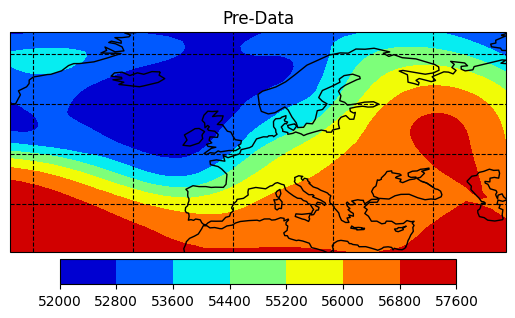

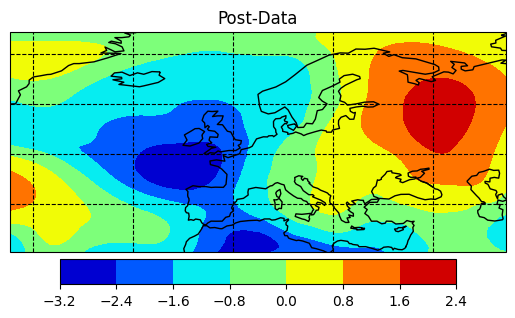

In [117]:
# plot pre-transform data and post-transform data

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

plt.contourf(pre_data[pre_lon], pre_data[pre_lat], pre_data[variable][0], transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('Pre-Data', size=12)
cb = plt.colorbar(ax=ax, orientation="horizontal", pad=0.02, aspect=16, shrink=0.8)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

plt.contourf(post_data[post_lon], post_data[post_lat], post_data[variable][0][0], transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('Post-Data', size=12)
cb = plt.colorbar(ax=ax, orientation="horizontal", pad=0.02, aspect=16, shrink=0.8)

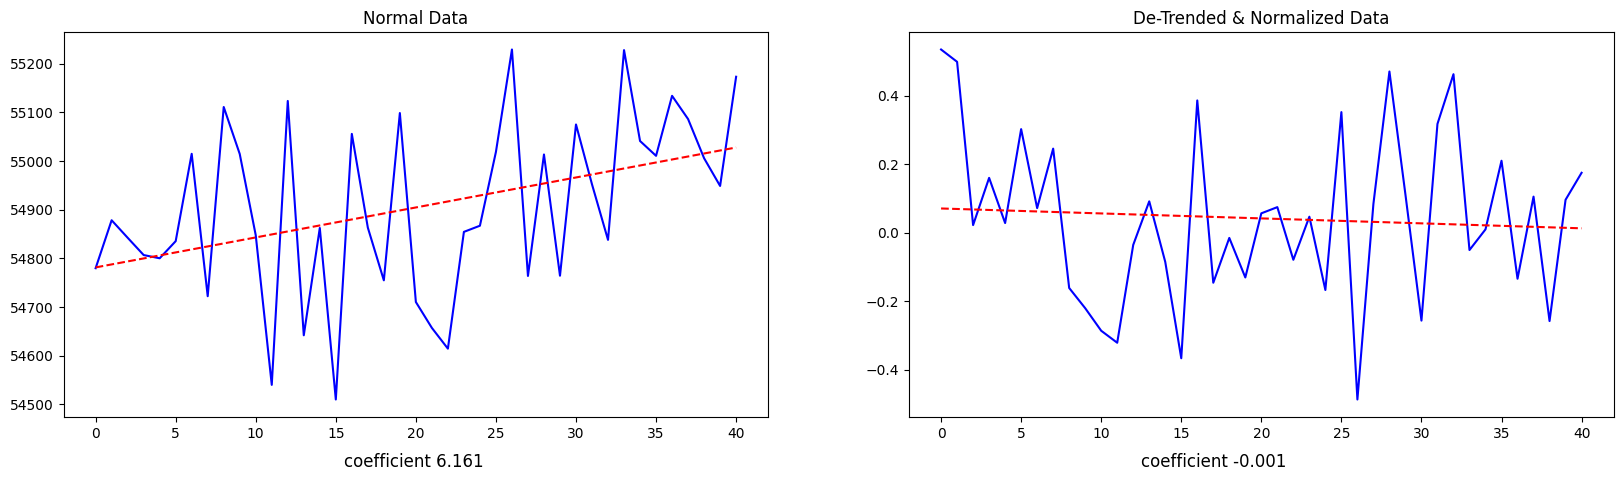

In [65]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20, 5))

# pre data
day = pre_data.sel(time=(pre_data["time.day"] == i+1) & (pre_data["time.month"] == 6))
grouped_data = day.groupby('time.year').mean(dim='time')
y = np.mean(grouped_data[variable].data, axis=(1,2))
x = np.arange(len(y))
coef1 = np.polyfit(x, y,1)
poly1d_fn = np.poly1d(coef1) 

# axs[0].ylabel(str(i+1) + ". Juni Berlin")
axs[0].set_title("Normal Data")
axs[0].plot(x, y, 'b-')
axs[0].plot(x, poly1d_fn(x), 'r--')

# post data
day = post_data.sel(time=(post_data["time.day"] == i+1) & (post_data["time.month"] == 6))
grouped_data = day.groupby('time.year').mean(dim='time')
y = np.mean(grouped_data[variable].data, axis=(2,3))[:,0]
x = np.arange(len(y))
coef2 = np.polyfit(x, y,1)
poly1d_fn = np.poly1d(coef2)

# axs[1].ylabel(str(i+1) + ". Juni Berlin")
axs[1].set_title("De-Trended & Normalized Data")
axs[1].plot(x, y, 'b-')
axs[1].plot(x, poly1d_fn(x), 'r--')

fig.text(0.3, 0.02, f'coefficient {coef1[0]:.3f}', ha='center', va='center', fontsize=12)
fig.text(0.7, 0.02, f'coefficient {coef2[0]:.3f}', ha='center', va='center', fontsize=12)

plt.show()

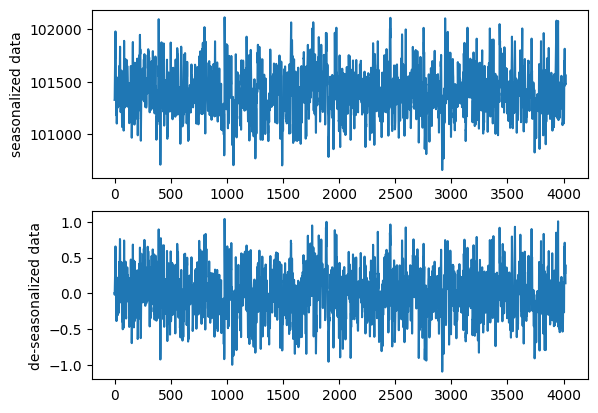

In [78]:
plt.subplot(2, 1, 1)
plt.ylabel("seasonalized data")
plt.plot(np.mean(pre_data[variable], axis=(1, 2)))

plt.subplot(2, 1, 2)
plt.ylabel("de-seasonalized data")
plt.plot(np.mean(post_data[variable][:,0], axis=(1, 2)))
plt.show()

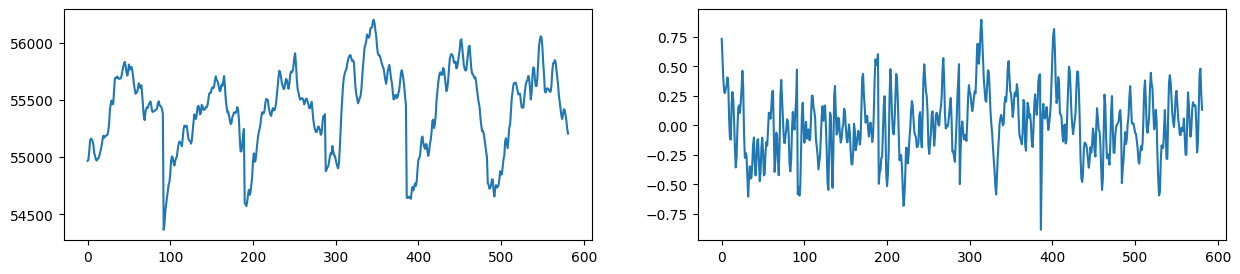

In [12]:
# year 1995-2000 compared between normal data and de-seasonalized data

fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axs[0].plot(pre_data.sel(time=slice("1995-06-01", "2000-08-31"))[variable].mean(dim=("latitude", "longitude")))

axs[1].plot(post_data.sel(time=slice("1995-06-01", "2000-08-31"))[variable].mean(dim=("latitude", "longitude"))[:,0])

plt.show()

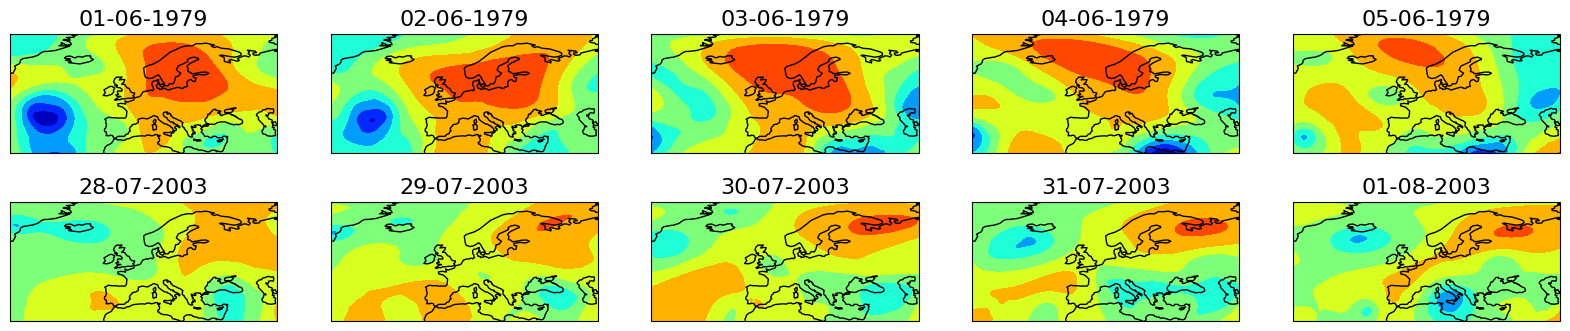

In [125]:
# plot two positve anomalies

fig, axs = plt.subplots(nrows=2,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 4))

axs = axs.flatten()

clevs=np.arange(-5,5,1)

time = datetime(year=1979, month=6, day=1)

for i in range(5):
    axs[i].coastlines(resolution="110m",linewidth=1)
    cs = axs[i].contourf(post_data[post_lon], post_data[post_lat], post_data.sel(time=time + timedelta(days=i), method="nearest")[variable].data[0], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    axs[i].set_title((time + timedelta(days=i)).strftime('%d-%m-%Y'), fontsize=16)
    # axs[i].set_title((time + timedelta(days=i)).strftime('%d-%m-%Y') + f" block: {labels.sel(time=time + timedelta(days=i), method='nearest')['blocking'].values}", fontsize=16)

time = datetime(year=2003, month=7, day=28)

for i in range(5):
    axs[i+5].coastlines(resolution="110m",linewidth=1)
    cs = axs[i+5].contourf(post_data[post_lon], post_data[post_lat], post_data.sel(time=time + timedelta(days=i), method="nearest")[variable].data[0], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    axs[i+5].set_title((time + timedelta(days=i)).strftime('%d-%m-%Y'), fontsize=16)
    # axs[i+5].set_title((time + timedelta(days=i)).strftime('%d-%m-%Y') + f" block: {labels.sel(time=time + timedelta(days=i), method='nearest')['blocking'].values}", fontsize=16)

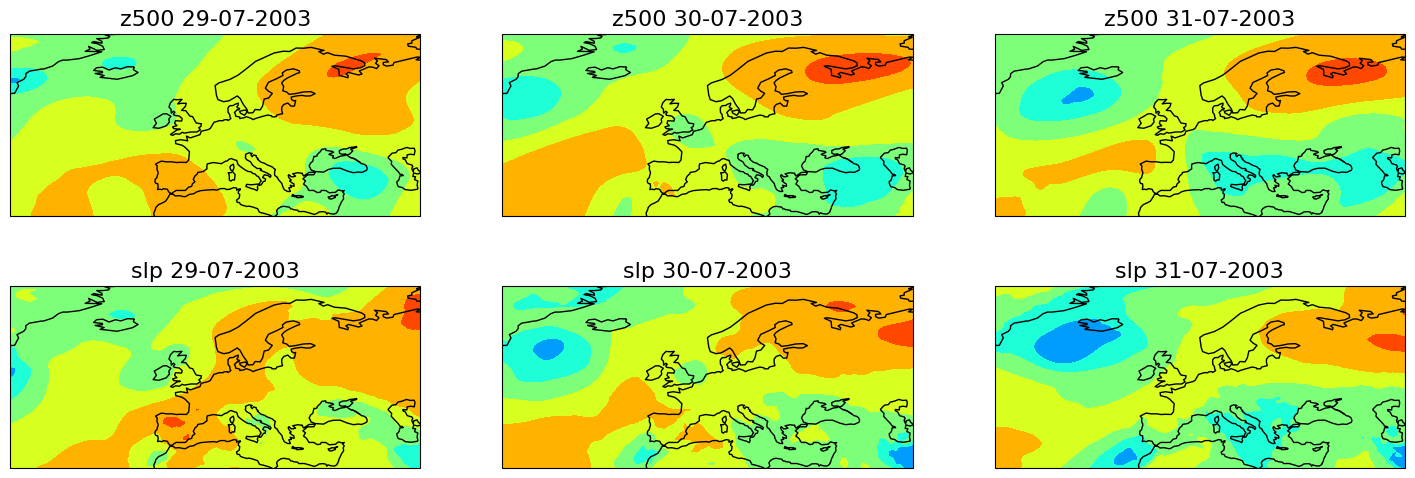

In [27]:
# noise comparison between z_500 and slp for the beginning of 2003 heat wave in Europe

fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18, 6))

axs = axs.flatten()

clevs=np.arange(-5,5,1)

time = datetime(year=2003, month=7, day=29)

for i in range(3):
    axs[i].coastlines(resolution="110m",linewidth=1)
    cs = axs[i].contourf(post_data[post_lon], post_data[post_lat], post_data.sel(time=time + timedelta(days=i), method="nearest")[variable].data[0], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    axs[i].set_title("z500 " + (time + timedelta(days=i)).strftime('%d-%m-%Y'), fontsize=16)

for i in range(3):
    axs[i+3].coastlines(resolution="110m",linewidth=1)
    cs = axs[i+3].contourf(post_data_msl["lon"], post_data_msl["lat"], post_data_msl.sel(time=time + timedelta(days=i), method="nearest")["msl"][0].data, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    axs[i+3].set_title("slp " + (time + timedelta(days=i)).strftime('%d-%m-%Y'), fontsize=16)

Text(0.5, 1.0, 'b) dipole blocking event on 28-07-1982')

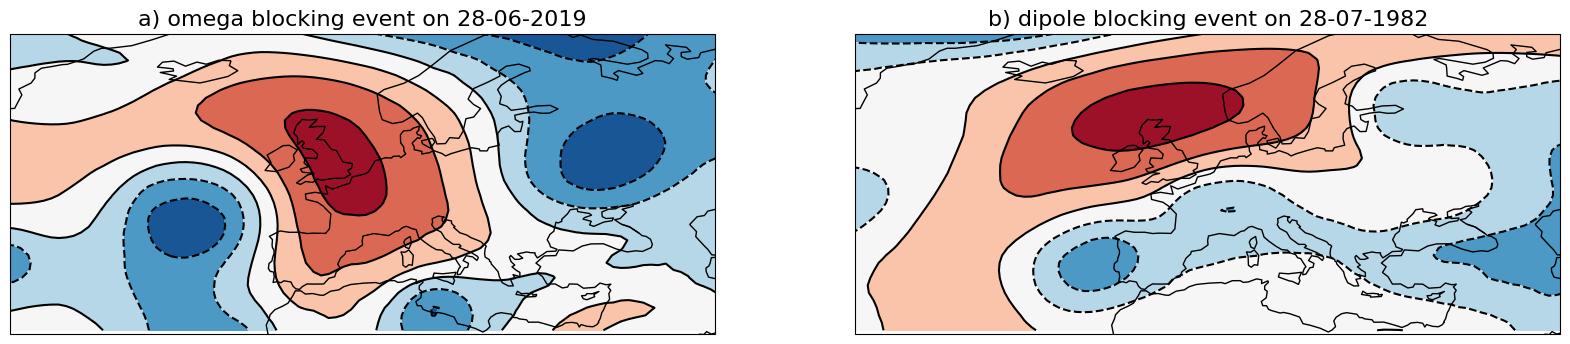

In [37]:
# plot an omega blocking event and dipole blocking event in the ERA5 dataset
time = datetime(year=2019, month=6, day=28)

fig, axs = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(20, 6), ncols=2)

for a in axs:
    a.coastlines(resolution="110m", linewidth=1)
    a.set_extent([-44, 50, 30, 70], crs=ccrs.PlateCarree())

cs = axs[0].contourf(
    post_data[post_lon],
    post_data[post_lat],
    post_data.sel(time=time, method="nearest")[variable].data[0],
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.RdBu_r,
)
cs = axs[0].contour(
    post_data[post_lon],
    post_data[post_lat],
    post_data.sel(time=time, method="nearest")[variable].data[0],
    transform=ccrs.PlateCarree(),
    colors="black",
)
axs[0].set_title("a) omega blocking event on " + time.strftime("%d-%m-%Y"), fontsize=16)

time = datetime(year=1982, month=7, day=28)

cs = axs[1].contourf(
    post_data[post_lon],
    post_data[post_lat],
    post_data.sel(time=time, method="nearest")[variable].data[0],
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.RdBu_r,
)
cs = axs[1].contour(
    post_data[post_lon],
    post_data[post_lat],
    post_data.sel(time=time, method="nearest")[variable].data[0],
    transform=ccrs.PlateCarree(),
    colors="black",
)
axs[1].set_title("b) dipole blocking event on " + time.strftime("%d-%m-%Y"), fontsize=16)

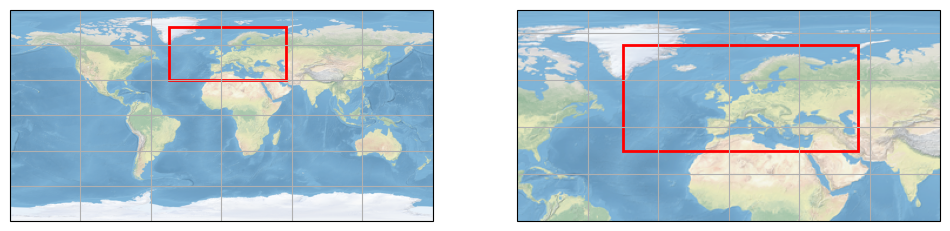

In [23]:
# Define bounding box
lon_range = (-45, 55)
lat_range = (30, 75)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5),
                               subplot_kw={'projection': ccrs.PlateCarree()},
                               gridspec_kw={'width_ratios': [1, 1]})

ax1.stock_img()
ax2.stock_img()
ax1.gridlines()
ax2.gridlines()

rect1 = plt.Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                      linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax1.add_patch(rect1)


rect1 = plt.Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                      linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax2.add_patch(rect1)

ax1.set_extent([-180, 180, -90, 90])
ax2.set_extent([-90, 90, 0, 90])

plt.show()

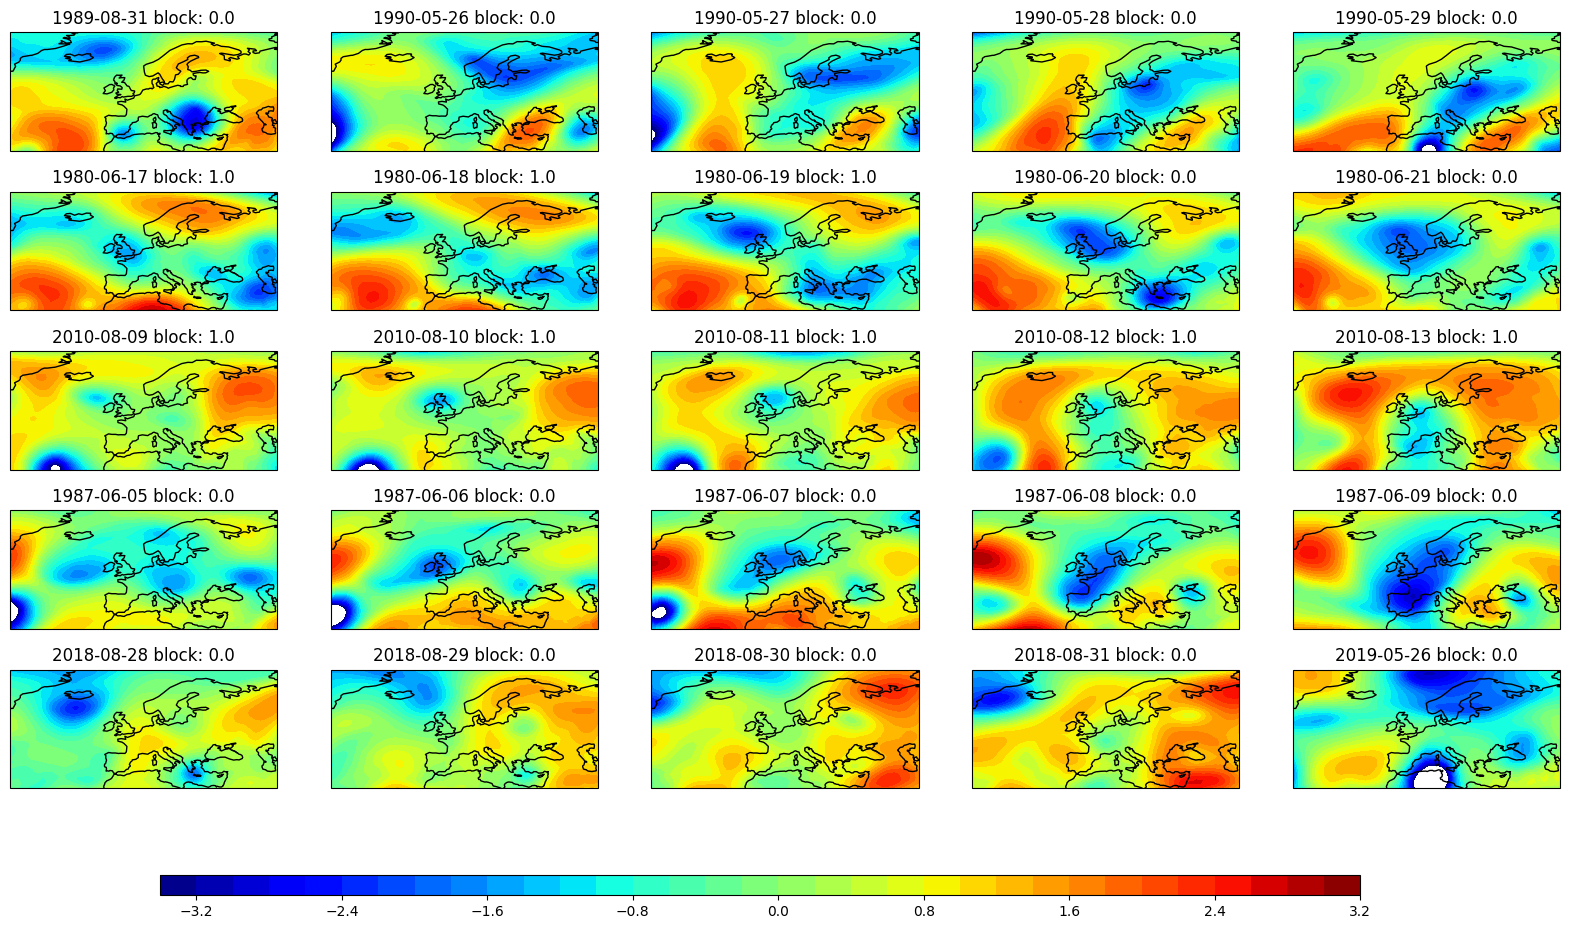

In [18]:
import random
import pandas as pd

fig, axs = plt.subplots(nrows=5,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 10))

axs = axs.flatten()

clevs=np.arange(-3.4,3.4,0.2)

for i in range(5):
    idx = random.randint(0, 4017)
    for j in range(5):
        axs[i*5 + j].coastlines(resolution="110m",linewidth=1)

        time = pd.to_datetime(str(post_data.time[idx + j].values))

        cs = axs[i*5 + j].contourf(post_data[post_lon], post_data[post_lat], post_data[variable][idx, j], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
        axs[i*5 + j].set_title(time.strftime('%Y-%m-%d') + (" block: " + str(labels["blocking"][idx + j].values)))

cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')